In [161]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

In [162]:
class Discriminator(nn.Module):
    def __init__(self,channels_img,features_d):
        super().__init__()
        self.disc=nn.Sequential(
            nn.Conv2d(in_channels=channels_img,out_channels=features_d,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            self._block(in_channels=features_d,out_channels=features_d*2,kernel_size=4,stride=2,padding=1),
            self._block(in_channels=features_d*2,out_channels=features_d*4,kernel_size=4,stride=2,padding=1),
            self._block(in_channels=features_d*4,out_channels=features_d*8,kernel_size=4,stride=2,padding=1),
            nn.Conv2d(in_channels=features_d*8,out_channels=1,kernel_size=4,stride=2,padding=0),
            nn.Sigmoid()        
        )

    
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self,x:torch.Tensor):
        return self.disc(x)
        
        

In [163]:
class Generator(nn.Module):
    def __init__(self,z_dim,channels_img,features_g):
        super().__init__()
        self.gen=nn.Sequential(
             self._block(in_channels=z_dim,out_channels=features_g*16,kernel_size=4,stride=1,padding=0),
             self._block(in_channels=features_g*16,out_channels=features_g*8,kernel_size=4,stride=2,padding=1),
             self._block(in_channels=features_g*8,out_channels=features_g*4,kernel_size=4,stride=2,padding=1),
             self._block(in_channels=features_g*4,out_channels=features_g*2,kernel_size=4,stride=2,padding=1),
             nn.ConvTranspose2d(in_channels=features_g*2,out_channels=channels_img,kernel_size=4,stride=2,padding=1),
             nn.Tanh()    
        )
        
       
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    
    def forward(self,x:torch.Tensor):
        return self.gen(x)

     
        

In [164]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data,0.0,0.02)
    

In [165]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device:{device}")

Using device:cuda


In [166]:
gen_lr=3e-4
disc_lr=1e-4
epochs=50
BATCH_SIZE=128
Z_DIM=100
CHANNELS_IMG=3
FEATURES_G=64
FEATURES_D=64
IMG_SIZE=256
transforms=transforms.Compose([
    transforms.Resize(size=(IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)],[0.5 for _ in range(CHANNELS_IMG)])
])

In [167]:
dataset=ImageFolder(root='celeb_dataset',transform=transforms,target_transform=None)
dataloader=DataLoader(dataset=dataset,batch_size=BATCH_SIZE,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


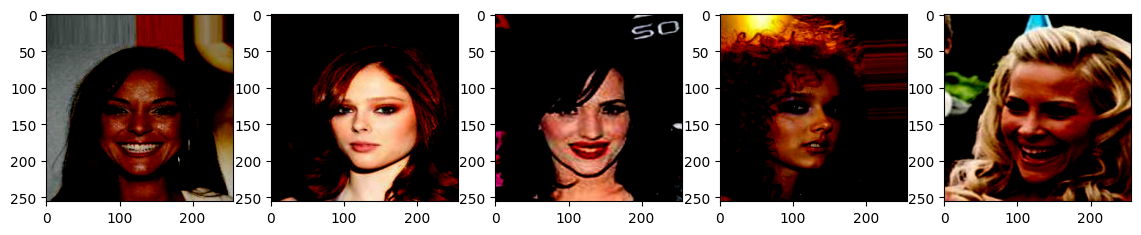

In [168]:
img_batch,_=next(iter(dataloader))
plt.figure(figsize=(14,7))
nrows,ncols=1,5
for i in range(1,6):
    plt.subplot(nrows,ncols,i)
    plt.imshow(img_batch[i].permute(1,2,0))


In [169]:
disc=Discriminator(channels_img=CHANNELS_IMG,features_d=FEATURES_D).to(device)
print(f"Discrimintaor network is running on {next(disc.parameters()).device}")
gen=Generator(z_dim=Z_DIM,channels_img=CHANNELS_IMG,features_g=FEATURES_G).to(device)
print(f"Generator network is running on {next(gen.parameters()).device}")

Discrimintaor network is running on cuda:0
Generator network is running on cuda:0


In [170]:
gen_opt=torch.optim.Adam(params=gen.parameters(),lr=gen_lr)
disc_opt=torch.optim.Adam(params=disc.parameters(),lr=disc_lr)
loss_fn=nn.BCELoss()

In [171]:
initialize_weights(gen)
initialize_weights(disc)

In [172]:
fixed_noise=torch.randn(32,Z_DIM,1,1).to(device)
writer_fake = SummaryWriter(f"runs/GAN_CELEB/fake")
writer_real = SummaryWriter(f"runs/GAN_CELEB/real")
step=0
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [173]:
for epoch in range(epochs):
    for batch_idx,(real,_) in enumerate(dataloader):
        real=real.to(device)
        batch_size=real.shape[0]
        noise=torch.randn(batch_size,Z_DIM,1,1).to(device)
        fake=gen(noise).to(device)
        disc_real=disc(real).reshape(-1)
        loss_real_disc=loss_fn(disc_real,torch.ones_like(disc_real))
        disc_fake=disc(fake).reshape(-1)
        loss_fake_disc=loss_fn(disc_fake,torch.zeros_like(disc_fake))
        loss_D=(loss_real_disc+loss_fake_disc)/2
        disc.zero_grad()
        loss_D.backward(retain_graph=True)
        disc_opt.step()

        output=disc(fake).reshape(-1)
        loss_G=loss_fn(output,torch.ones_like(output))
        gen.zero_grad()
        loss_G.backward()
        gen_opt.step()

        if batch_idx % 100 ==0:
            print(f"Epoch:[{epoch}/{epochs}] Batch_idx:{batch_idx}/{len(dataloader)} Loss D: {loss_D:.4f}, loss G: {loss_G:.4f}")

            with torch.inference_mode():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
    
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
            step +=1
        
        
        
        
        

Epoch:[0/50] Batch_idx:0/8 Loss D: 0.6947, loss G: 0.7512
Epoch:[1/50] Batch_idx:0/8 Loss D: 0.5711, loss G: 1.0302
Epoch:[2/50] Batch_idx:0/8 Loss D: 0.5140, loss G: 1.2104
Epoch:[3/50] Batch_idx:0/8 Loss D: 0.4729, loss G: 1.3532
Epoch:[4/50] Batch_idx:0/8 Loss D: 0.4382, loss G: 1.4725
Epoch:[5/50] Batch_idx:0/8 Loss D: 0.4162, loss G: 1.5480
Epoch:[6/50] Batch_idx:0/8 Loss D: 0.3727, loss G: 1.7070
Epoch:[7/50] Batch_idx:0/8 Loss D: 0.3339, loss G: 1.8588
Epoch:[8/50] Batch_idx:0/8 Loss D: 0.2976, loss G: 1.9930
Epoch:[9/50] Batch_idx:0/8 Loss D: 0.2658, loss G: 2.1154
Epoch:[10/50] Batch_idx:0/8 Loss D: 0.2381, loss G: 2.2192
Epoch:[11/50] Batch_idx:0/8 Loss D: 0.2326, loss G: 2.2437
Epoch:[12/50] Batch_idx:0/8 Loss D: 0.1989, loss G: 2.3956
Epoch:[13/50] Batch_idx:0/8 Loss D: 0.1706, loss G: 2.5625
Epoch:[14/50] Batch_idx:0/8 Loss D: 0.1481, loss G: 2.6673
Epoch:[15/50] Batch_idx:0/8 Loss D: 0.1298, loss G: 2.7710
Epoch:[16/50] Batch_idx:0/8 Loss D: 0.1156, loss G: 2.8643
Epoch:[

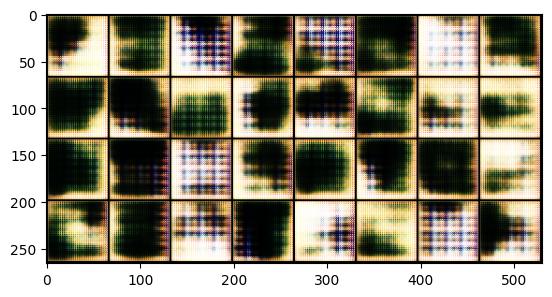

In [174]:
plt.imshow(img_grid_fake.permute(1,2,0).cpu().numpy())